# Inequality constraints

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1799)
tf.random.set_seed(1799)

## The problem

In this tutorial, we replicate one of the results of <cite data-cite="gardner14">[Gardner et al.](http://proceedings.mlr.press/v32/gardner14.html)</cite>, specifically their synthetic experiment "simulation 1", which consists of an objective function with a single constraint, defined over a two-dimensional input domain. We'll start by defining the problem parameters.  The constraint is satisfied when `constraint(input_data) <= threshold`.

In [2]:
from trieste.space import Box


class Sim:
    threshold = 0.5

    @staticmethod
    def objective(input_data):
        x, y = input_data[..., -2], input_data[..., -1]
        z = tf.cos(2.0 * x) * tf.cos(y) + tf.sin(x)
        return z[:, None]

    @staticmethod
    def constraint(input_data):
        x, y = input_data[:, -2], input_data[:, -1]
        z = tf.cos(x) * tf.cos(y) - tf.sin(x) * tf.sin(y)
        return z[:, None]


search_space = Box([0, 0], [6, 6])

The objective and constraint functions are accessible as methods on the `Sim` class. Let's visualise these functions, as well as the constrained objective.  We get the constrained objective by masking out regions where the constraint function is above the threshold.

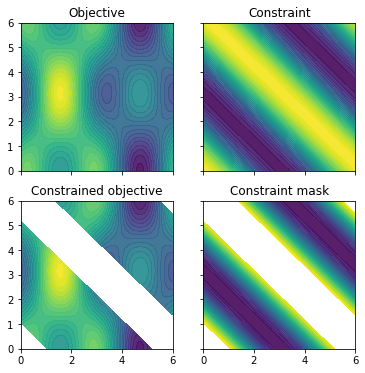

In [3]:
import trieste
import matplotlib.pyplot as plt
from util.inequality_constraints_utils import plot_objective_and_constraints

plot_objective_and_constraints(search_space, Sim)
plt.show()

We'll make an observer that outputs both the objective and constraint data. Since the observer is outputting multiple datasets, we have to label them so that the optimization process knows which is which.

In [4]:
from trieste.data import Dataset

OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"


def observer(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim.objective(query_points)),
        CONSTRAINT: Dataset(query_points, Sim.constraint(query_points)),
    }

Let's randomly sample some initial data from the observer ...

In [5]:
num_initial_points = 5
initial_data = observer(search_space.sample(num_initial_points))

... and visualise those points on the constrained objective. Note how the generated data is labelled, like the observer.

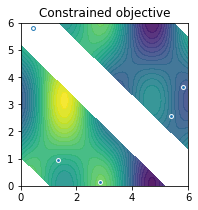

In [6]:
from util.inequality_constraints_utils import plot_init_query_points

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
)
plt.show()

## Modelling the two functions

We'll model the objective and constraint data with their own Gaussian process regression model, as implemented in GPflow. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `GPR` model and pass it to the `GaussianProcessRegression` wrapper.

In [7]:
import gpflow

from trieste.models.gpflow.models import GaussianProcessRegression


def create_bo_model(data):
    variance = tf.math.reduce_variance(data.observations)
    lengthscale = 1.0 * np.ones(2, dtype=gpflow.default_float())
    kernel = gpflow.kernels.Matern52(
        variance=variance, lengthscales=lengthscale
    )
    jitter = gpflow.kernels.White(1e-12)
    gpr = gpflow.models.GPR(
        data.astuple(), kernel + jitter, noise_variance=1e-5
    )
    gpflow.set_trainable(gpr.likelihood, False)
    return GaussianProcessRegression(gpr)


initial_models = trieste.utils.map_values(create_bo_model, initial_data)

## Define the acquisition process

We can construct the _expected constrained improvement_ acquisition function defined in <cite data-cite="gardner14">[Gardner et al.](http://proceedings.mlr.press/v32/gardner14.html)</cite>, where they use the probability of feasibility with respect to the constraint model.

In [8]:
from trieste.acquisition.rule import EfficientGlobalOptimization

pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    OBJECTIVE, pof.using(CONSTRAINT)
)
rule = EfficientGlobalOptimization(eci)  # type: ignore

## Run the optimization loop

We can now run the optimization loop. We obtain the final objective and constraint data using `.try_get_final_datasets()`.

In [9]:
num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

data = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

Optimization completed without errors


To conclude this section, we visualise the resulting data. Orange dots show the new points queried during optimization. Notice the concentration of these points in regions near the local minima.

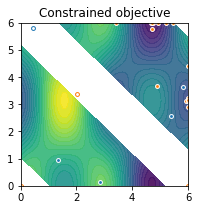

In [10]:
constraint_data = data[CONSTRAINT]
new_query_points = constraint_data.query_points[-num_steps:]
new_observations = constraint_data.observations[-num_steps:]
new_data = (new_query_points, new_observations)

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
    new_data,
)
plt.show()

## Batch-sequential strategy

We'll now look at a batch-sequential approach to the same problem. Sometimes it's beneficial to query several points at a time instead of one. The acquisition function we used earlier, built by `ExpectedConstrainedImprovement`, only supports a batch size of 1, so we'll need a new acquisition function builder for larger batch sizes. We can implement this using the reparametrization trick with the Monte-Carlo sampler `BatchReparametrizationSampler`. Note that when we do this, we must initialise the sampler *outside* the acquisition function (here `batch_efi`). This is crucial: a given instance of a sampler produces repeatable, continuous samples, and we can use this to create a repeatable continuous acquisition function. Using a new sampler on each call would not result in a repeatable continuous acquisition function.

In [11]:
class BatchExpectedConstrainedImprovement(
    trieste.acquisition.AcquisitionFunctionBuilder
):
    def __init__(self, sample_size, threshold):
        self._sample_size = sample_size
        self._threshold = threshold

    def prepare_acquisition_function(self, models, datasets):
        objective_model = models[OBJECTIVE]
        objective_dataset = datasets[OBJECTIVE]

        samplers = {
            tag: trieste.models.gpflow.BatchReparametrizationSampler(
                self._sample_size, model
            )
            for tag, model in models.items()
        }

        pf = trieste.acquisition.probability_of_feasibility(
            models[CONSTRAINT], self._threshold
        )(tf.expand_dims(objective_dataset.query_points, 1))
        is_feasible = pf >= 0.5

        mean, _ = objective_model.predict(objective_dataset.query_points)
        eta = tf.reduce_min(tf.boolean_mask(mean, is_feasible), axis=0)

        def batch_efi(at):
            samples = {
                tag: tf.squeeze(sampler.sample(at), -1)
                for tag, sampler in samplers.items()
            }
            feasible_mask = samples[CONSTRAINT] < self._threshold  # [N, S, B]
            improvement = tf.where(
                feasible_mask, tf.maximum(eta - samples[OBJECTIVE], 0.0), 0.0
            )  # [N, S, B]
            batch_improvement = tf.reduce_max(improvement, axis=-1)  # [N, S]
            return tf.reduce_mean(
                batch_improvement, axis=-1, keepdims=True
            )  # [N, 1]

        return batch_efi


num_query_points = 4
sample_size = 50
batch_eci = BatchExpectedConstrainedImprovement(sample_size, Sim.threshold)
batch_rule = EfficientGlobalOptimization(  # type: ignore
    batch_eci, num_query_points=num_query_points
)

We can now run the BO loop as before; note that here we also query twenty points, but in five batches of four points.

In [12]:
initial_models = trieste.utils.map_values(create_bo_model, initial_data)

num_steps = 5
batch_data = bo.optimize(
    num_steps, initial_data, initial_models, batch_rule, track_state=False
).try_get_final_datasets()

Optimization completed without errors


We visualise the resulting data as before.

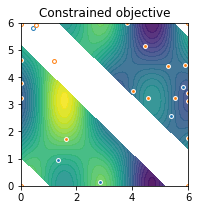

In [13]:
batch_constraint_data = batch_data[CONSTRAINT]
new_batch_data = (
    batch_constraint_data.query_points[-num_query_points * num_steps :],
    batch_constraint_data.observations[-num_query_points * num_steps :],
)

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
    new_batch_data,
)
plt.show()

Finally, we compare the regret from the non-batch strategy (left panel) to the regret from the batch strategy (right panel).
In the following plots each marker represents a query point. The x-axis is the index of the query point (where the first queried point has index 0), and the y-axis is the observed value. The vertical blue line denotes the end of initialisation/start of optimisation. Green points satisfy the constraint, red points do not.

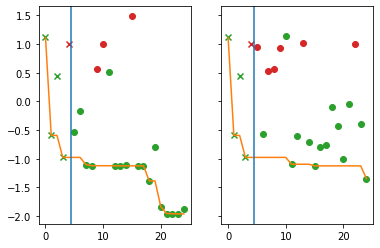

In [14]:
from util.plotting import plot_regret

mask_fail = constraint_data.observations.numpy() > Sim.threshold
batch_mask_fail = batch_constraint_data.observations.numpy() > Sim.threshold

fig, ax = plt.subplots(1, 2, sharey="all")
plot_regret(
    data[OBJECTIVE].observations.numpy(),
    ax[0],
    num_init=num_initial_points,
    mask_fail=mask_fail.flatten(),
)
plot_regret(
    batch_data[OBJECTIVE].observations.numpy(),
    ax[1],
    num_init=num_initial_points,
    mask_fail=batch_mask_fail.flatten(),
)

## Constrained optimization with more than one constraint

We'll now show how to use a reducer to combine multiple constraints. The new problem `Sim2` inherits from the previous one its objective and first constraint, but also adds a second constraint. We start by adding an output to our observer, and creating a set of three models.

In [15]:
class Sim2(Sim):
    threshold2 = 0.5

    @staticmethod
    def constraint2(input_data):
        x, y = input_data[:, -2], input_data[:, -1]
        z = tf.sin(x) * tf.cos(y) - tf.cos(x) * tf.sin(y)
        return z[:, None]


CONSTRAINT2 = "CONSTRAINT2"


def observer_two_constraints(query_points):
    return {
        OBJECTIVE: Dataset(query_points, Sim2.objective(query_points)),
        CONSTRAINT: Dataset(query_points, Sim2.constraint(query_points)),
        CONSTRAINT2: Dataset(query_points, Sim2.constraint2(query_points)),
    }


num_initial_points = 10
initial_data = observer_two_constraints(search_space.sample(num_initial_points))
initial_models = trieste.utils.map_values(create_bo_model, initial_data)

Now, the probability that the two constraints are feasible is the product of the two feasibilities. Hence, we combine the two `ProbabilityOfFeasibility` functions into one quantity by using a `Product` `Reducer`:

In [16]:
from trieste.acquisition.combination import Product

pof1 = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim2.threshold)
pof2 = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim2.threshold2)
pof = Product(pof1.using(CONSTRAINT), pof2.using(CONSTRAINT2))  # type: ignore

We can now run the BO loop as before, and visualize the results:

Optimization completed without errors


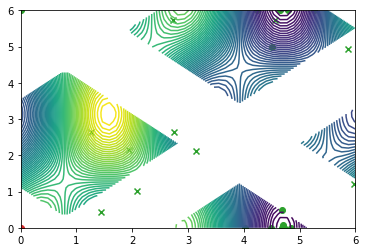

In [17]:
eci = trieste.acquisition.ExpectedConstrainedImprovement(OBJECTIVE, pof)  # type: ignore
rule = EfficientGlobalOptimization(eci)

num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(
    observer_two_constraints, search_space
)

data = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

constraint_data = data[CONSTRAINT]
new_query_points = constraint_data.query_points[-num_steps:]
new_observations = constraint_data.observations[-num_steps:]
new_data = (new_query_points, new_observations)


def masked_objective(x):
    mask_nan = np.logical_or(
        Sim2.constraint(x) > Sim2.threshold,
        Sim2.constraint2(x) > Sim2.threshold2,
    )
    y = np.array(Sim2.objective(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)


mask_fail1 = (
    data[CONSTRAINT].observations.numpy().flatten().astype(int) > Sim2.threshold
)
mask_fail2 = (
    data[CONSTRAINT].observations.numpy().flatten().astype(int)
    > Sim2.threshold2
)
mask_fail = np.logical_or(mask_fail1, mask_fail2)

import matplotlib.pyplot as plt
from util.plotting import plot_function_2d, plot_bo_points

fig, ax = plot_function_2d(
    masked_objective,
    search_space.lower,
    search_space.upper,
    grid_density=50,
    contour=True,
)
plot_bo_points(
    data[OBJECTIVE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=num_initial_points,
    mask_fail=mask_fail,
)
plt.show()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)